# VECM
- Using a VECM to predict FANG stocks
- See the [VECM documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm)

In [18]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.Pipeline import Transformer, Reverter, MVPipeline
from scalecast.util import find_optimal_lag_order, find_optimal_coint_rank
from scalecast.auxmodels import vecm
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
import matplotlib.pyplot as plt

In [2]:
yf.pdr_override()

## Download data using a public API

In [3]:
FANG = [
    'META',
    'AMZN',
    'NFLX',
    'GOOG',
]

fs = []
for sym in FANG:
    df = pdr.get_data_yahoo(sym)
    df = df.asfreq('B', method='ffill')
    f = Forecaster(
        y=df['Close'],
        current_dates = df.index,
        future_dates = 65,
        end = '2022-09-30',
    )
    fs.append(f)
    
mvf = MVForecaster(*fs,names=FANG,test_length=65)
mvf.set_validation_metric('rmse')
mvf.add_sklearn_estimator(vecm,'vecm')

mvf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MVForecaster(
    DateStartActuals=2012-05-18T00:00:00.000000000
    DateEndActuals=2023-04-11T00:00:00.000000000
    Freq=B
    N_actuals=2843
    N_series=4
    SeriesNames=['META', 'AMZN', 'NFLX', 'GOOG']
    ForecastLength=65
    Xvars=[]
    TestLength=65
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

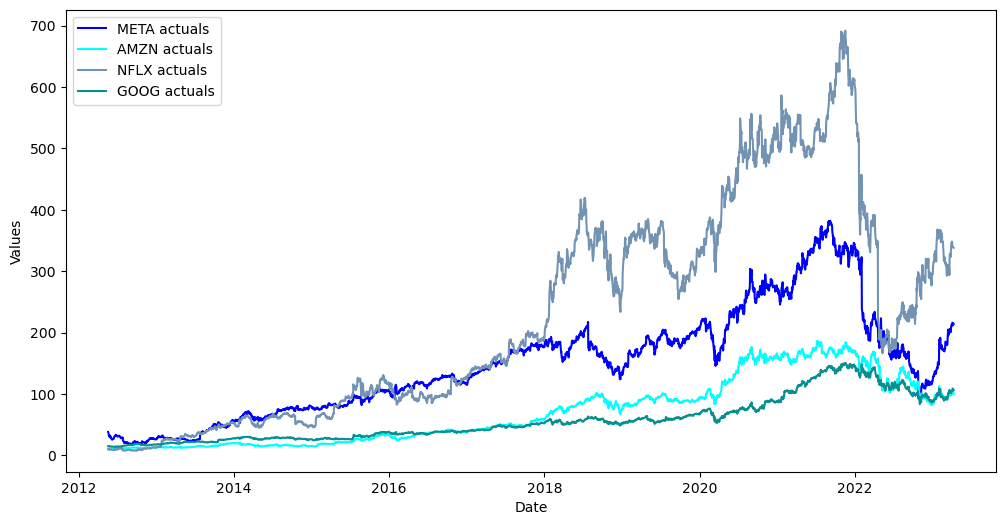

In [4]:
mvf.plot()
plt.show()

## Augmented Dickey Fuller Tests to Confirm Unit-1 Roots

In [5]:
for stock, f in zip(FANG,fs):
    adf_result = f.adf_test(full_res=True)
    print('the stock {} is {}stationary at level'.format(
        stock,
        'not ' if adf_result[1] > 0.05 else ''
    )
    )

the stock META is not stationary at level
the stock AMZN is not stationary at level
the stock NFLX is not stationary at level
the stock GOOG is not stationary at level


In [6]:
for stock, f in zip(FANG,fs):
    adf_result = f.adf_test(diffy=True,full_res=True)
    print('the stock {} is {}stationary at its first difference'.format(
        stock,
        'not ' if adf_result[1] > 0.05 else ''
    )
    )

the stock META is stationary at its first difference
the stock AMZN is stationary at its first difference
the stock NFLX is stationary at its first difference
the stock GOOG is stationary at its first difference


## Measure IC to Find Optimal Lag Order
- this is used to run the cointegration test

In [7]:
lag_test = find_optimal_lag_order(mvf,train_only=True)
pd.DataFrame(
    {
        'aic':lag_test.aic,
        'bic':lag_test.bic,
        'hqic':lag_test.hqic,
        'fpe':lag_test.fpe,
    },
    index = ['optimal lag order'],
).T

,optimal lag order
aic,27
bic,1
hqic,3
fpe,27


## Johansen cointegration test

In [8]:
coint_res = find_optimal_coint_rank(
    mvf,
    det_order=1,
    k_ar_diff=10,
    train_only=True,
)
print(coint_res)
coint_res.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          56.90          55.25
  1   4          34.45          35.01
-------------------------------------


1

We found a cointegration rank of 1.

## Run VECM
- Now, we can specify a grid that will try more lags, deterministic terms, seasonal fluctuations, and cointegration ranks of 0 and 1

In [9]:
vecm_grid = dict(
    lags = [0], # required to set this to 0 for the vecm model in scalecast
    freq = ['B'], # only necessary to suppress a warning
    k_ar_diff = range(1,66),
    coint_rank = [0,1],
    deterministic = ["n","co","lo","li","cili","colo"],
    seasons = [0,5,30,65,260],
)

mvf.set_estimator('vecm')
mvf.ingest_grid(vecm_grid)
mvf.limit_grid_size(100,random_seed=20)
mvf.cross_validate(k=3,verbose=True)
mvf.auto_forecast()

results = mvf.export('model_summaries')
results[[
    'ModelNickname',
    'Series',
    'TestSetRMSE',
    'TestSetMAE',
]]

Num hyperparams to try for the vecm model: 100.
Fold 0: Train size: 2084 (2012-05-18 00:00:00 - 2020-05-13 00:00:00). Test Size: 694 (2020-05-14 00:00:00 - 2023-01-10 00:00:00). 
Fold 1: Train size: 1390 (2012-05-18 00:00:00 - 2017-09-14 00:00:00). Test Size: 694 (2017-09-15 00:00:00 - 2020-05-13 00:00:00). 
Fold 2: Train size: 696 (2012-05-18 00:00:00 - 2015-01-16 00:00:00). Test Size: 694 (2015-01-19 00:00:00 - 2017-09-14 00:00:00). 
Chosen paramaters: {'lags': 0, 'freq': 'B', 'k_ar_diff': 59, 'coint_rank': 1, 'deterministic': 'co', 'seasons': 65}.


,ModelNickname,Series,TestSetRMSE,TestSetMAE
0,vecm,META,63.951105,56.389782
1,vecm,AMZN,13.726549,13.297016
2,vecm,NFLX,40.655282,34.901358
3,vecm,GOOG,17.724305,16.219936


## View VECM Results

In [10]:
results['TestSetRMSE'].mean()

34.01431037289139

In [11]:
mvf.export_validation_grid('vecm').sample(15)

,lags,freq,k_ar_diff,coint_rank,deterministic,seasons,Fold0Metric,Fold1Metric,Fold2Metric,AverageMetric,MetricEvaluated,Optimized On
59,0,B,20,0,cili,5,NaN,NaN,NaN,NaN,rmse,mean
89,0,B,62,1,cili,65,84.374983,53.526896,36.373698,58.091859,rmse,mean
95,0,B,57,1,cili,5,84.341112,41.674828,39.885354,55.300431,rmse,mean
42,0,B,36,0,cili,5,NaN,NaN,NaN,NaN,rmse,mean
68,0,B,49,0,lo,0,105.250868,44.094622,22.713694,57.353061,rmse,mean
40,0,B,7,0,li,260,NaN,NaN,NaN,NaN,rmse,mean
72,0,B,15,1,colo,260,100.743090,36.385686,38.716525,58.615100,rmse,mean
94,0,B,38,1,colo,5,107.075177,36.351161,47.468481,63.631606,rmse,mean
28,0,B,40,1,co,65,84.839068,43.635687,24.716157,51.063637,rmse,mean
90,0,B,11,0,colo,5,109.141457,43.263732,44.838163,65.747784,rmse,mean


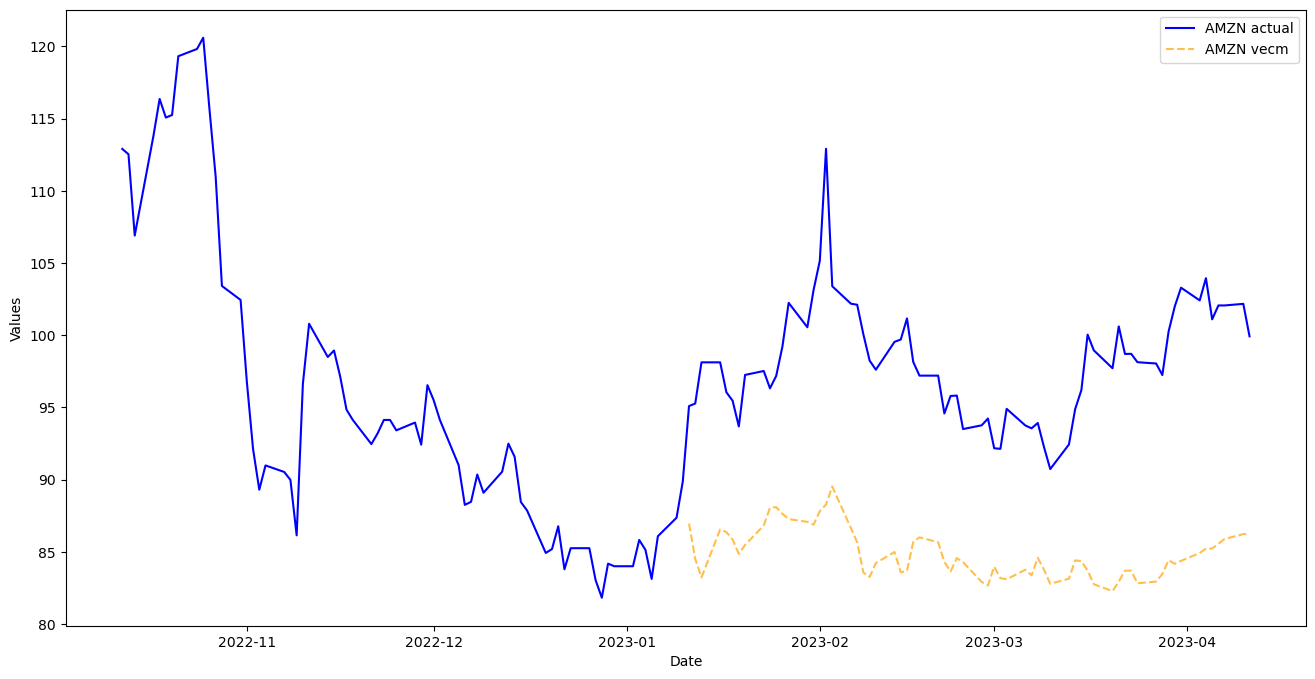

In [12]:
mvf.plot_test_set(
    series='AMZN',
    models='vecm',
    include_train=130,
    figsize=(16,8)
)
plt.show()

## Re-weight Evaluation Metrics and Rerun VECM

In [13]:
weights = results['TestSetRMSE'] / results['TestSetRMSE'].sum()
weights

0    0.470031
1    0.100888
2    0.298810
3    0.130271
Name: TestSetRMSE, dtype: float64

In [14]:
mvf.set_optimize_on(
    lambda x: (
        x[0]*weights[0] + 
        x[1]*weights[1] + 
        x[2]*weights[2] + 
        x[3]*weights[3]
    )
)
mvf.ingest_grid(vecm_grid)
mvf.limit_grid_size(100,random_seed=20)
mvf.cross_validate(k=3,verbose=True)
mvf.auto_forecast(call_me='vecm_weighted')

results = mvf.export('model_summaries')
results[[
    'ModelNickname',
    'Series',
    'TestSetRMSE',
    'TestSetMAE',
]]

Num hyperparams to try for the vecm model: 100.
Fold 0: Train size: 2084 (2012-05-18 00:00:00 - 2020-05-13 00:00:00). Test Size: 694 (2020-05-14 00:00:00 - 2023-01-10 00:00:00). 
Fold 1: Train size: 1390 (2012-05-18 00:00:00 - 2017-09-14 00:00:00). Test Size: 694 (2017-09-15 00:00:00 - 2020-05-13 00:00:00). 
Fold 2: Train size: 696 (2012-05-18 00:00:00 - 2015-01-16 00:00:00). Test Size: 694 (2015-01-19 00:00:00 - 2017-09-14 00:00:00). 
Chosen paramaters: {'lags': 0, 'freq': 'B', 'k_ar_diff': 28, 'coint_rank': 1, 'deterministic': 'li', 'seasons': 5}.


,ModelNickname,Series,TestSetRMSE,TestSetMAE
0,vecm,META,63.951105,56.389782
1,vecm_weighted,META,54.938329,48.492363
2,vecm,AMZN,13.726549,13.297016
3,vecm_weighted,AMZN,17.071250,15.898881
4,vecm,NFLX,40.655282,34.901358
5,vecm_weighted,NFLX,39.905317,34.542291
6,vecm,GOOG,17.724305,16.219936
7,vecm_weighted,GOOG,20.631421,18.586238


In [15]:
results.loc[results['ModelNickname'] == 'vecm_weighted','TestSetRMSE'].mean()

33.13657951810128

A slight improvement by weighting the optimizer!

In [ ]:
mvf.plot_test_set(
    series='META',
    models='all',
    include_train=130,
    figsize=(16,8)
)
plt.show()

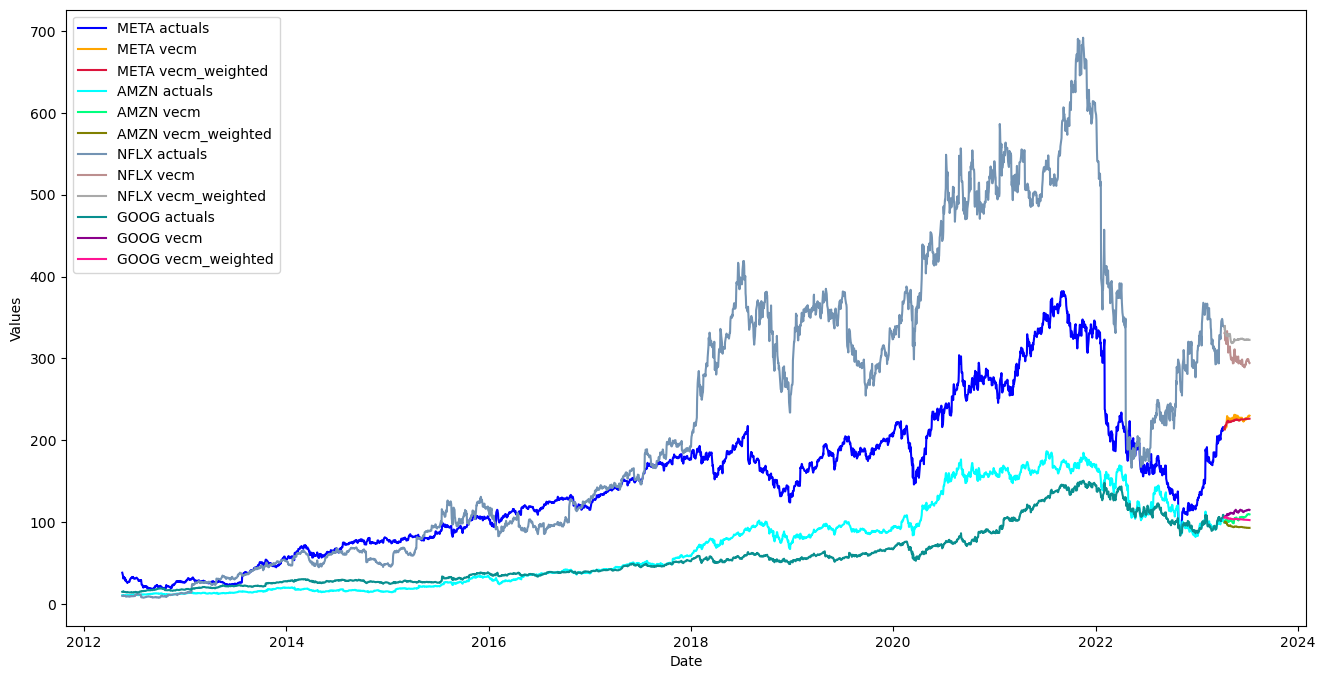

In [17]:
mvf.plot(
    series='all',
    models='all',
    figsize=(16,8)
)
plt.show()

## Try Other MV Models

In [19]:
GridGenerator.get_mv_grids()
# open MVGrids.py and manually change all lags arguments to range(1,66)

In [22]:
transformers = []
reverters = []
for stock, f in zip(FANG,fs):
    transformer = Transformer(
        transformers = [('DiffTransform',)]
    )
    reverter = Reverter(
        reverters = [('DiffRevert',)],
        base_transformer = transformer,
    )
    transformers.append(transformer)
    reverters.append(reverter)

In [23]:
def Xvar_select(f):
    f.set_validation_length(65)
    f.auto_Xvar_select(
        estimator='rf',
        max_depth=2,
        max_ar=0
    )

def mvforecaster(mvf):
    models = (
        'mlr',
        'elasticnet',
        'gbt',
        'xgboost',
        'lightgbm',
        'knn',
    )
    mvf.set_test_length(65)
    mvf.tune_test_forecast(
        models,
        limit_grid_size=50,
        cross_validate=True,
        k=3,
    )

In [24]:
pipeline = MVPipeline(
    steps = [
        ('Transform',transformers),
        ('Xvar Select',[Xvar_select]*4),
        ('Forecast',mvforecaster),
        ('Revert',reverters),
    ],
    names = FANG,
)

In [25]:
fs = pipeline.fit_predict(*fs)

Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations


In [30]:
results = export_model_summaries(dict(zip(FANG,fs)))

## View Results

In [31]:
model_rmses = results.groupby('ModelNickname')['TestSetRMSE'].mean().sort_values().reset_index()
model_rmses

,ModelNickname,TestSetRMSE
0,elasticnet,23.016082
1,lightgbm,23.250509
2,mlr,23.595660
3,knn,24.100863
4,xgboost,24.127559
5,gbt,24.294648


The above table is the mean mape performance from each model over all series.

In [32]:
series_rmses = results.groupby('Series')['TestSetRMSE'].min().reset_index()
series_rmses['Model'] = [results.loc[results['TestSetRMSE'] == i,'ModelNickname'].values[0] for i in series_rmses['TestSetRMSE']]
series_rmses

,Series,TestSetRMSE,Model
0,AMZN,8.378915,elasticnet
1,GOOG,9.922327,elasticnet
2,META,37.857279,xgboost
3,NFLX,22.486811,knn


In [34]:
series_rmses['TestSetRMSE'].mean()

19.661332972781906

The above table shows the best model for each series and its derived RMSE. The average RMSE of all these models applied to the individual series is ..., but being so dependent on the test set to choose the model probably leads to overfitting.

In [39]:
FANG

['META', 'AMZN', 'NFLX', 'GOOG']

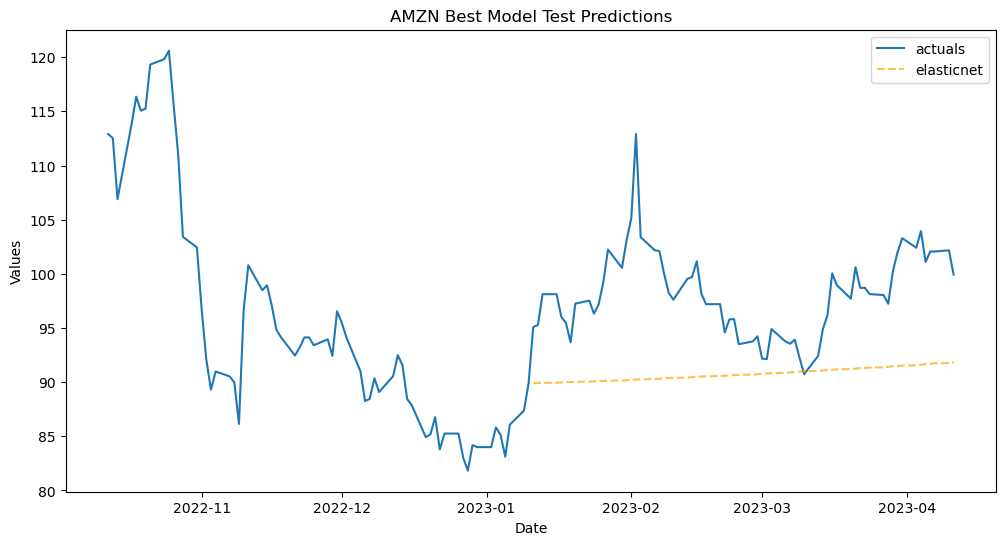

In [41]:
fs[1].plot_test_set(
    models='elasticnet',
    include_train=130,
)
plt.title('AMZN Best Model Test Predictions')
plt.show()

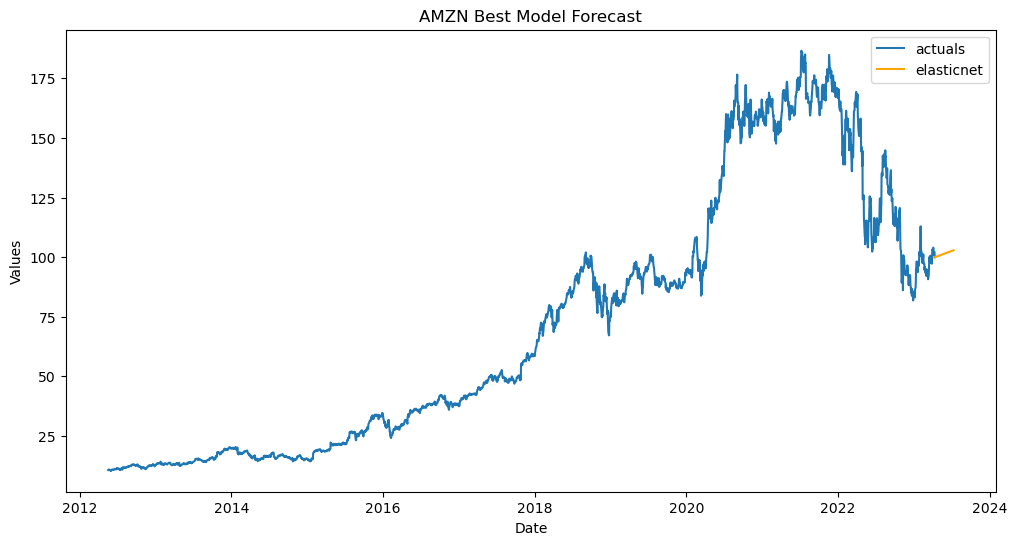

In [42]:
fs[1].plot(
    models='elasticnet',
)
plt.title('AMZN Best Model Forecast')
plt.show()